# Feasibility analysis

Based on achievable self-interference level

## Setup

Imports and data loading

In [1]:
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import json

from cissir import visualization as viz
from cissir.utils import res_path

viz.talk_style(line_cycler=False)

In [2]:
rank_cols = ["spec_nuc_tx", "spec_nuc_rx"]
si_cols = ["ach_si"]
deg_cols = ["tx_degrees", "rx_degrees"]
rank_list = []
si_list = []

for fname in res_path.rglob("*beam*.json"):
    with open(fname, 'r', encoding ='utf8') as json_file:
        beam_res = json.load(json_file)
        
    del beam_res["beam_dev_tx"]
    del beam_res["beam_dev_rx"]
    
    tx_info = beam_res.pop("tx")
    rx_info = beam_res.pop("rx")

    beam_df = pd.DataFrame(beam_res)
    
    if rank_cols[0] in beam_df.columns:
        rank_df = beam_df.drop(columns="ach_si")
        rank_df = rank_df.assign(tx_degrees=[tx_info["degrees"]] * len(beam_df),
                                 rx_degrees=[rx_info["degrees"]] * len(beam_df)).explode(rank_cols + deg_cols)
        rank_df = rank_df.astype(dtype={k: float for k in rank_cols + deg_cols})
        rank_list.extend([rank_df.assign(side=sd, beam_degs=rank_df[f"{sd}_degrees"],
                                       spec_nuc=rank_df[f"spec_nuc_{sd}"]).drop(columns=rank_cols + deg_cols)
                        for sd in ("tx", "rx")])
        
        beam_df = beam_df.drop(columns=rank_cols)
    
    tx_grid = tx_info["grid"]
    rx_grid = rx_info["grid"]
    
    si_df = pd.DataFrame(beam_df)
    si_df["tx_degrees"] = [tx_grid] * len(si_df)
    si_df["rx_degrees"] = [rx_grid] * len(si_df)
    si_df = si_df.explode(column=si_cols + deg_cols)
    si_df = si_df.dropna().sample(frac=1)
    si_list.append(si_df)

rank_df = pd.concat(rank_list)
si_df = pd.concat(si_list).astype(dtype={k: float for k in si_cols + deg_cols})

## Rank of SDP solutions

In [3]:
rank_df

,opt,taps,tgt_si,side,beam_degs,spec_nuc
0,sdr,1,-60.557639,tx,-54.340912,0.999993
0,sdr,1,-60.557639,tx,-48.590378,1.000000
0,sdr,1,-60.557639,tx,-43.432537,0.999960
0,sdr,1,-60.557639,tx,-38.682187,0.999958
0,sdr,1,-60.557639,tx,-34.228866,0.999958
...,...,...,...,...,...,...
69,sdr,full,-123.487686,rx,34.228866,0.999998
69,sdr,full,-123.487686,rx,38.682187,0.999990
69,sdr,full,-123.487686,rx,43.432537,0.999996
69,sdr,full,-123.487686,rx,48.590378,0.999998


In [4]:
spec_nuc_cut = 0.99

avg_df = rank_df.groupby(["taps", "side", "tgt_si"])[["spec_nuc"]].mean().reset_index("tgt_si")
cutoff_df = avg_df.query(f"spec_nuc < {spec_nuc_cut}").groupby(["taps", "side"])[["tgt_si"]].max()
cutoff_df

tgt_si
taps side            
1    rx   -122.557639
     tx   -122.557639
full rx   -108.487686
     tx   -108.487686

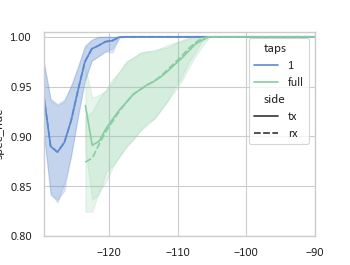

In [5]:
_, ax = plt.subplots()
sns.lineplot(rank_df.query("tgt_si < -80"), x="tgt_si", y="spec_nuc", style="side", hue="taps", ax=ax)
ax.set_ylim(0.8, 1.005)
_ = ax.set_xlim(rank_df['tgt_si'].min(), -90)

## SI gap

In [6]:
si_df["si_gap"] = si_df["tgt_si"] - si_df["ach_si"]
si_df

,opt,taps,tgt_si,ach_si,tx_degrees,rx_degrees,si_gap
36,sdr,1,-96.557639,-96.743528,-43.432537,-25.944480,0.185890
43,sdr,1,-103.557639,-104.553390,48.590378,30.000000,0.995751
7,sdr,1,-67.557639,-88.114865,18.209957,14.477512,20.557227
37,sdr,1,-97.557639,-103.404742,-7.180756,-30.000000,5.847104
27,sdr,1,-87.557639,-91.407378,-30.000000,54.340912,3.849740
...,...,...,...,...,...,...,...
50,spectral,full,-104.487686,-106.378128,30.000000,48.590378,1.890442
29,spectral,full,-83.487686,-86.781626,-18.209957,14.477512,3.293941
23,spectral,full,-77.487686,-77.680910,34.228866,18.209957,0.193224
70,spectral,full,-124.487686,-130.657352,-48.590378,3.583322,6.169667


In [7]:
si_df["si_gap"] = si_df["tgt_si"] - si_df["ach_si"]
gap_df = si_df.groupby(["opt", "taps", "tgt_si"])["si_gap"].min().reset_index()

max_gap = gap_df.groupby(["opt", "taps"])["si_gap"].max().reset_index().pivot(index="taps", columns="opt", values="si_gap").reset_index()
max_gap

opt,taps,sdr,spectral
0,1,0.000803,0.504710
1,full,0.401353,1.906563


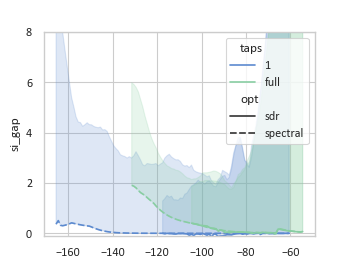

In [8]:
_, ax = plt.subplots()
_ = sns.lineplot(si_df, x="tgt_si", y="si_gap", hue="taps", style="opt",
                 estimator=min, errorbar=lambda x: (np.min(x), np.median(x)), ax=ax)
_ = plt.ylim(-0.1, 8)

### Beam-pair SI plots

In [9]:
plot_df = si_df.query("opt == 'spectral' and taps == 'full'").sample(frac=0.1)
si_tx = plot_df.rename(columns={"tx_degrees": "angle"}).assign(side="TX")
si_rx = plot_df.rename(columns={"rx_degrees": "angle"}).assign(side="RX")

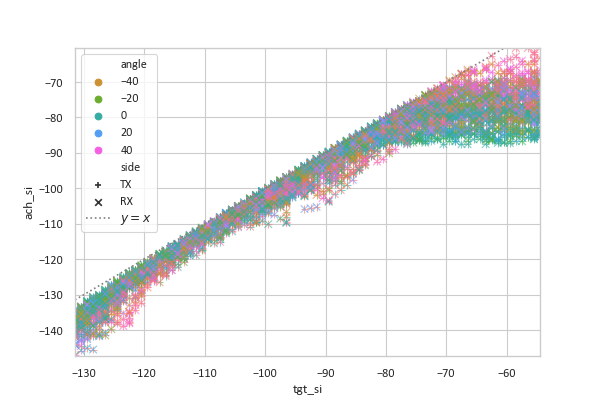

In [10]:
markersize = 6
markevery = 10

plot_df = pd.concat([si_tx, si_rx])

_, ax = plt.subplots(figsize=(6,4))

xcol, ycol = "tgt_si", "ach_si"

xmin, xmax = plot_df[xcol].min(), plot_df[xcol].max()
ymin, ymax = plot_df[ycol].min(), plot_df[ycol].max()

ang_order = np.sort(plot_df.angle.unique()).astype(str)
sns.scatterplot(plot_df, x=xcol, y=ycol, linewidth=0.8,
                alpha=0.6, palette="husl", s=30, edgecolor=None,
                size_order=("TX", "RX"), style_order=("TX", "RX"),
                style="side", markers=["+", "x"], hue="angle", ax=ax)
plt.plot([xmin, xmax], [xmin, xmax], ":", c="gray", label="$y=x$")
ax.legend()
_ = ax.set_xlim(xmin, xmax)
_ = ax.set_ylim(ymin, ymax)